#### Imports

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from catboost import CatBoostClassifier, Pool 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix


#### Read in Dataset

In [2]:
dogs = pd.read_csv('../data/dogs.csv', parse_dates=['intake_datetime'])

In [3]:
dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70917 entries, 0 to 70916
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   animal_id             70917 non-null  object        
 1   intake_datetime       70917 non-null  datetime64[ns]
 2   name                  58825 non-null  object        
 3   intake_type           70917 non-null  object        
 4   intake_condition      70917 non-null  object        
 5   animal_type           70917 non-null  object        
 6   intake_sex            70916 non-null  object        
 7   intake_spay_neuter    70916 non-null  object        
 8   intake_age_in_years   70917 non-null  float64       
 9   age_group             70917 non-null  object        
 10  breed                 70917 non-null  object        
 11  breed_1               70917 non-null  object        
 12  breed_2               11609 non-null  object        
 13  mix_flag        

#### Feature Selection

In [4]:
dogs['intake_year'] = dogs['intake_datetime'].dt.year.astype('object')
dogs['intake_month'] = dogs['intake_datetime'].dt.month.astype('object')

In [5]:
target_map = {
    'Adoption':'Other',
    'Return to Owner':'Return to Owner',
    'Transfer':'Other',
    'Euthanasia':'Other',
    'Rto-Adopt':'Other',
    'Died':'Other',
    'Missing':'Other',
    'Disposal':'Other'
}

dogs['outcome_type'] = dogs['outcome_type'].map(target_map)

In [6]:
dogs = dogs.dropna(subset=['outcome_type', 'intake_sex'])

In [7]:
dogs = dogs[dogs['intake_condition'] == 'Normal']

In [8]:
features = [
    'intake_type',
    'intake_year',
    'intake_month',
    'intake_spay_neuter',
    'intake_age_in_years',
    'breed'
]

target = ['outcome_type']

In [9]:
X = dogs[features]
y = dogs[target]

#### CatBoost Category Columns

In [10]:
#CatBoost requires the specification of categorical columns. This function gets the list of categorical indicies

def get_categorical_indicies(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        cat_indicies.append(X.columns.get_loc(col))
    return cat_indicies

categorical_indicies = get_categorical_indicies(X)

In [11]:
categorical_indicies

[0, 1, 2, 3, 5]

In [12]:
#CatBoost needs the categorical columns to be converted to the categorical datatype

def convert_cats(X):
    cats = []
    for col in X.columns:
        if is_numeric_dtype(X[col]):
            pass
        else:
            cats.append(col)
    cat_indicies = []
    for col in cats:
        X[col] = X[col].astype('category')

convert_cats(X)

<ipython-input-12-6025a30c5164>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


#### Train, Test, Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=63)

#### SMOTE

In [14]:
oversampler = SMOTENC(k_neighbors=5, n_jobs=-1, random_state=63, categorical_features=categorical_indicies)

In [15]:
X_smote, y_smote = oversampler.fit_resample(X_train, y_train)

#### Pool

In [16]:
train_dataset = Pool(X_smote, 
                     y_smote,
                     cat_features=categorical_indicies
                    )
test_dataset = Pool(X_test, 
                    y_test,
                    cat_features=categorical_indicies
                   )

In [45]:
clf.classes_

array(['Other', 'Return to Owner'], dtype=object)

#### Model Training and Prediction

In [50]:
clf = CatBoostClassifier(loss_function='Logloss', eval_metric='F1')

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,],
        'iterations': [50, 100, 150]}

clf.grid_search(grid, train_dataset)

preds = clf.predict(X_test)

print(preds)

0:	learn: 0.7162406	test: 0.7123980	best: 0.7123980 (0)	total: 30.1ms	remaining: 1.47s
1:	learn: 0.7162751	test: 0.7126081	best: 0.7126081 (1)	total: 46.9ms	remaining: 1.13s
2:	learn: 0.7163622	test: 0.7126081	best: 0.7126081 (1)	total: 61.9ms	remaining: 969ms
3:	learn: 0.7163392	test: 0.7126081	best: 0.7126081 (1)	total: 74.8ms	remaining: 860ms
4:	learn: 0.7170583	test: 0.7132377	best: 0.7132377 (4)	total: 84.9ms	remaining: 764ms
5:	learn: 0.7170324	test: 0.7132377	best: 0.7132377 (4)	total: 97.1ms	remaining: 712ms
6:	learn: 0.7170064	test: 0.7132377	best: 0.7132377 (4)	total: 109ms	remaining: 667ms
7:	learn: 0.7170102	test: 0.7132377	best: 0.7132377 (4)	total: 120ms	remaining: 632ms
8:	learn: 0.7169987	test: 0.7132377	best: 0.7132377 (4)	total: 131ms	remaining: 598ms
9:	learn: 0.7169987	test: 0.7132377	best: 0.7132377 (4)	total: 144ms	remaining: 576ms
10:	learn: 0.7170247	test: 0.7132377	best: 0.7132377 (4)	total: 155ms	remaining: 550ms
11:	learn: 0.7170247	test: 0.7132377	best: 0.71

1:	learn: 0.7162751	test: 0.7126081	best: 0.7126081 (1)	total: 33.5ms	remaining: 804ms
2:	learn: 0.7163477	test: 0.7126081	best: 0.7126081 (1)	total: 50.6ms	remaining: 792ms
3:	learn: 0.7163217	test: 0.7126081	best: 0.7126081 (1)	total: 66.9ms	remaining: 769ms
4:	learn: 0.7163362	test: 0.7126081	best: 0.7126081 (1)	total: 84.8ms	remaining: 764ms
5:	learn: 0.7163392	test: 0.7126081	best: 0.7126081 (1)	total: 107ms	remaining: 781ms
6:	learn: 0.7163392	test: 0.7126081	best: 0.7126081 (1)	total: 133ms	remaining: 815ms
7:	learn: 0.7163683	test: 0.7126081	best: 0.7126081 (1)	total: 152ms	remaining: 796ms
8:	learn: 0.7163483	test: 0.7126081	best: 0.7126081 (1)	total: 169ms	remaining: 768ms
9:	learn: 0.7163628	test: 0.7126081	best: 0.7126081 (1)	total: 181ms	remaining: 724ms
10:	learn: 0.7163628	test: 0.7126081	best: 0.7126081 (1)	total: 194ms	remaining: 688ms
11:	learn: 0.7163628	test: 0.7126081	best: 0.7126081 (1)	total: 205ms	remaining: 649ms
12:	learn: 0.7163628	test: 0.7126081	best: 0.712

44:	learn: 0.7857447	test: 0.7789698	best: 0.7793221 (37)	total: 740ms	remaining: 82.2ms
45:	learn: 0.7856991	test: 0.7787095	best: 0.7793221 (37)	total: 762ms	remaining: 66.3ms
46:	learn: 0.7857383	test: 0.7785044	best: 0.7793221 (37)	total: 784ms	remaining: 50.1ms
47:	learn: 0.7854013	test: 0.7781492	best: 0.7793221 (37)	total: 799ms	remaining: 33.3ms
48:	learn: 0.7853390	test: 0.7780545	best: 0.7793221 (37)	total: 820ms	remaining: 16.7ms
49:	learn: 0.7854214	test: 0.7783945	best: 0.7793221 (37)	total: 836ms	remaining: 0us

bestTest = 0.779322082
bestIteration = 37

3:	loss: 0.7793221	best: 0.7793221 (3)	total: 2.87s	remaining: 35.8s
0:	learn: 0.7162406	test: 0.7123980	best: 0.7123980 (0)	total: 25.3ms	remaining: 1.24s
1:	learn: 0.7162751	test: 0.7126081	best: 0.7126081 (1)	total: 45.8ms	remaining: 1.1s
2:	learn: 0.7170782	test: 0.7132377	best: 0.7132377 (2)	total: 65.3ms	remaining: 1.02s
3:	learn: 0.7170262	test: 0.7132377	best: 0.7132377 (2)	total: 82.5ms	remaining: 949ms
4:	learn:

47:	learn: 0.7836357	test: 0.7768137	best: 0.7774780 (33)	total: 624ms	remaining: 26ms
48:	learn: 0.7844979	test: 0.7772802	best: 0.7774780 (33)	total: 643ms	remaining: 13.1ms
49:	learn: 0.7845827	test: 0.7773354	best: 0.7774780 (33)	total: 653ms	remaining: 0us

bestTest = 0.7774779892
bestIteration = 33

5:	loss: 0.7774780	best: 0.7793221 (3)	total: 4.27s	remaining: 34.1s
0:	learn: 0.7162406	test: 0.7123980	best: 0.7123980 (0)	total: 18.5ms	remaining: 1.83s
1:	learn: 0.7162751	test: 0.7126081	best: 0.7126081 (1)	total: 31.3ms	remaining: 1.53s
2:	learn: 0.7163622	test: 0.7126081	best: 0.7126081 (1)	total: 43.7ms	remaining: 1.41s
3:	learn: 0.7163392	test: 0.7126081	best: 0.7126081 (1)	total: 56.1ms	remaining: 1.35s
4:	learn: 0.7170583	test: 0.7132377	best: 0.7132377 (4)	total: 67.9ms	remaining: 1.29s
5:	learn: 0.7170324	test: 0.7132377	best: 0.7132377 (4)	total: 80.7ms	remaining: 1.26s
6:	learn: 0.7170064	test: 0.7132377	best: 0.7132377 (4)	total: 92.8ms	remaining: 1.23s
7:	learn: 0.717

96:	learn: 0.7828692	test: 0.7752953	best: 0.7753505 (93)	total: 1.18s	remaining: 36.6ms
97:	learn: 0.7830618	test: 0.7760472	best: 0.7760472 (97)	total: 1.2s	remaining: 24.5ms
98:	learn: 0.7829478	test: 0.7760472	best: 0.7760472 (97)	total: 1.21s	remaining: 12.3ms
99:	learn: 0.7828183	test: 0.7756118	best: 0.7760472 (97)	total: 1.23s	remaining: 0us

bestTest = 0.7760472228
bestIteration = 97

6:	loss: 0.7760472	best: 0.7793221 (3)	total: 5.52s	remaining: 37.1s
0:	learn: 0.7162406	test: 0.7123980	best: 0.7123980 (0)	total: 16.1ms	remaining: 1.59s
1:	learn: 0.7162751	test: 0.7126081	best: 0.7126081 (1)	total: 28.9ms	remaining: 1.42s
2:	learn: 0.7170782	test: 0.7132377	best: 0.7132377 (2)	total: 39.6ms	remaining: 1.28s
3:	learn: 0.7168244	test: 0.7131328	best: 0.7132377 (2)	total: 50.7ms	remaining: 1.22s
4:	learn: 0.7168359	test: 0.7131328	best: 0.7132377 (2)	total: 61.4ms	remaining: 1.17s
5:	learn: 0.7165389	test: 0.7128180	best: 0.7132377 (2)	total: 71.4ms	remaining: 1.12s
6:	learn: 0.

0:	learn: 0.7162406	test: 0.7123980	best: 0.7123980 (0)	total: 24ms	remaining: 2.38s
1:	learn: 0.7162751	test: 0.7126081	best: 0.7126081 (1)	total: 38.3ms	remaining: 1.88s
2:	learn: 0.7163477	test: 0.7126081	best: 0.7126081 (1)	total: 51.9ms	remaining: 1.68s
3:	learn: 0.7163217	test: 0.7126081	best: 0.7126081 (1)	total: 64.4ms	remaining: 1.55s
4:	learn: 0.7163362	test: 0.7126081	best: 0.7126081 (1)	total: 75.8ms	remaining: 1.44s
5:	learn: 0.7163392	test: 0.7126081	best: 0.7126081 (1)	total: 86.4ms	remaining: 1.35s
6:	learn: 0.7163392	test: 0.7126081	best: 0.7126081 (1)	total: 97.7ms	remaining: 1.3s
7:	learn: 0.7163683	test: 0.7126081	best: 0.7126081 (1)	total: 109ms	remaining: 1.25s
8:	learn: 0.7163483	test: 0.7126081	best: 0.7126081 (1)	total: 121ms	remaining: 1.22s
9:	learn: 0.7163628	test: 0.7126081	best: 0.7126081 (1)	total: 133ms	remaining: 1.19s
10:	learn: 0.7163628	test: 0.7126081	best: 0.7126081 (1)	total: 144ms	remaining: 1.17s
11:	learn: 0.7163628	test: 0.7126081	best: 0.7126

99:	learn: 0.7828170	test: 0.7760706	best: 0.7760706 (99)	total: 1.27s	remaining: 0us

bestTest = 0.7760705648
bestIteration = 99

8:	loss: 0.7760706	best: 0.7867851 (7)	total: 8.02s	remaining: 40.1s
0:	learn: 0.7162406	test: 0.7123980	best: 0.7123980 (0)	total: 20.1ms	remaining: 1.99s
1:	learn: 0.7162751	test: 0.7126081	best: 0.7126081 (1)	total: 33.2ms	remaining: 1.63s
2:	learn: 0.7170782	test: 0.7132377	best: 0.7132377 (2)	total: 43.4ms	remaining: 1.4s
3:	learn: 0.7170194	test: 0.7130733	best: 0.7132377 (2)	total: 53.9ms	remaining: 1.29s
4:	learn: 0.7170645	test: 0.7132377	best: 0.7132377 (2)	total: 64.8ms	remaining: 1.23s
5:	learn: 0.7170614	test: 0.7132377	best: 0.7132377 (2)	total: 74.5ms	remaining: 1.17s
6:	learn: 0.7168335	test: 0.7131328	best: 0.7132377 (2)	total: 84.6ms	remaining: 1.12s
7:	learn: 0.7546257	test: 0.7502591	best: 0.7502591 (7)	total: 94.5ms	remaining: 1.09s
8:	learn: 0.7625321	test: 0.7573416	best: 0.7573416 (8)	total: 106ms	remaining: 1.07s
9:	learn: 0.7631449

93:	learn: 0.7897861	test: 0.7851410	best: 0.7851410 (93)	total: 1.25s	remaining: 80ms
94:	learn: 0.7905027	test: 0.7857143	best: 0.7857143 (94)	total: 1.27s	remaining: 66.9ms
95:	learn: 0.7905366	test: 0.7852830	best: 0.7857143 (94)	total: 1.28s	remaining: 53.5ms
96:	learn: 0.7906274	test: 0.7851968	best: 0.7857143 (94)	total: 1.29s	remaining: 40ms
97:	learn: 0.7908059	test: 0.7855418	best: 0.7857143 (94)	total: 1.31s	remaining: 26.7ms
98:	learn: 0.7907249	test: 0.7858767	best: 0.7858767 (98)	total: 1.32s	remaining: 13.3ms
99:	learn: 0.7907729	test: 0.7860138	best: 0.7860138 (99)	total: 1.33s	remaining: 0us

bestTest = 0.7860137872
bestIteration = 99

9:	loss: 0.7860138	best: 0.7867851 (7)	total: 9.38s	remaining: 41.3s
0:	learn: 0.7162406	test: 0.7123980	best: 0.7123980 (0)	total: 16.4ms	remaining: 1.62s
1:	learn: 0.7162751	test: 0.7126081	best: 0.7126081 (1)	total: 28.8ms	remaining: 1.41s
2:	learn: 0.7170782	test: 0.7132377	best: 0.7132377 (2)	total: 40.7ms	remaining: 1.32s
3:	learn:

95:	learn: 0.7786376	test: 0.7721402	best: 0.7722829 (88)	total: 1.17s	remaining: 48.8ms
96:	learn: 0.7787721	test: 0.7721402	best: 0.7722829 (88)	total: 1.19s	remaining: 36.7ms
97:	learn: 0.7788391	test: 0.7722278	best: 0.7722829 (88)	total: 1.2s	remaining: 24.5ms
98:	learn: 0.7790129	test: 0.7731033	best: 0.7731033 (98)	total: 1.22s	remaining: 12.3ms
99:	learn: 0.7790702	test: 0.7731033	best: 0.7731033 (98)	total: 1.23s	remaining: 0us

bestTest = 0.7731032516
bestIteration = 98

10:	loss: 0.7731033	best: 0.7867851 (7)	total: 10.6s	remaining: 41.6s
0:	learn: 0.7162406	test: 0.7123980	best: 0.7123980 (0)	total: 16.6ms	remaining: 1.64s
1:	learn: 0.7162751	test: 0.7126081	best: 0.7126081 (1)	total: 29.7ms	remaining: 1.45s
2:	learn: 0.7170782	test: 0.7132377	best: 0.7132377 (2)	total: 42.6ms	remaining: 1.38s
3:	learn: 0.7170262	test: 0.7132377	best: 0.7132377 (2)	total: 54.1ms	remaining: 1.3s
4:	learn: 0.7168244	test: 0.7131328	best: 0.7132377 (2)	total: 65.2ms	remaining: 1.24s
5:	learn: 

94:	learn: 0.7909911	test: 0.7848119	best: 0.7850202 (93)	total: 1.18s	remaining: 62.1ms
95:	learn: 0.7913478	test: 0.7850706	best: 0.7850706 (95)	total: 1.2s	remaining: 49.9ms
96:	learn: 0.7923379	test: 0.7858713	best: 0.7858713 (96)	total: 1.21s	remaining: 37.4ms
97:	learn: 0.7923138	test: 0.7858106	best: 0.7858713 (96)	total: 1.22s	remaining: 25ms
98:	learn: 0.7920918	test: 0.7858055	best: 0.7858713 (96)	total: 1.23s	remaining: 12.5ms
99:	learn: 0.7920631	test: 0.7859171	best: 0.7859171 (99)	total: 1.25s	remaining: 0us

bestTest = 0.7859170926
bestIteration = 99

11:	loss: 0.7859171	best: 0.7867851 (7)	total: 11.9s	remaining: 41.7s
0:	learn: 0.7162406	test: 0.7123980	best: 0.7123980 (0)	total: 15.5ms	remaining: 2.31s
1:	learn: 0.7162751	test: 0.7126081	best: 0.7126081 (1)	total: 26.9ms	remaining: 1.99s
2:	learn: 0.7163622	test: 0.7126081	best: 0.7126081 (1)	total: 38.9ms	remaining: 1.9s
3:	learn: 0.7163392	test: 0.7126081	best: 0.7126081 (1)	total: 50.3ms	remaining: 1.84s
4:	learn: 

98:	learn: 0.7829478	test: 0.7760472	best: 0.7760472 (97)	total: 1.36s	remaining: 699ms
99:	learn: 0.7828183	test: 0.7756118	best: 0.7760472 (97)	total: 1.38s	remaining: 688ms
100:	learn: 0.7827968	test: 0.7756118	best: 0.7760472 (97)	total: 1.39s	remaining: 676ms
101:	learn: 0.7835362	test: 0.7763083	best: 0.7763083 (101)	total: 1.41s	remaining: 664ms
102:	learn: 0.7835563	test: 0.7763635	best: 0.7763635 (102)	total: 1.42s	remaining: 650ms
103:	learn: 0.7836071	test: 0.7763083	best: 0.7763635 (102)	total: 1.44s	remaining: 636ms
104:	learn: 0.7836224	test: 0.7763401	best: 0.7763635 (102)	total: 1.45s	remaining: 621ms
105:	learn: 0.7836578	test: 0.7763401	best: 0.7763635 (102)	total: 1.46s	remaining: 606ms
106:	learn: 0.7838087	test: 0.7763401	best: 0.7763635 (102)	total: 1.47s	remaining: 591ms
107:	learn: 0.7836425	test: 0.7762531	best: 0.7763635 (102)	total: 1.48s	remaining: 576ms
108:	learn: 0.7836056	test: 0.7763635	best: 0.7763635 (102)	total: 1.49s	remaining: 561ms
109:	learn: 0.7

43:	learn: 0.7835820	test: 0.7768771	best: 0.7781875 (29)	total: 562ms	remaining: 1.35s
44:	learn: 0.7837780	test: 0.7769006	best: 0.7781875 (29)	total: 578ms	remaining: 1.35s
45:	learn: 0.7839027	test: 0.7774223	best: 0.7781875 (29)	total: 593ms	remaining: 1.34s
46:	learn: 0.7841767	test: 0.7781250	best: 0.7781875 (29)	total: 608ms	remaining: 1.33s
47:	learn: 0.7841878	test: 0.7780619	best: 0.7781875 (29)	total: 621ms	remaining: 1.32s
48:	learn: 0.7842045	test: 0.7776988	best: 0.7781875 (29)	total: 631ms	remaining: 1.3s
49:	learn: 0.7840909	test: 0.7773193	best: 0.7781875 (29)	total: 645ms	remaining: 1.29s
50:	learn: 0.7839167	test: 0.7770501	best: 0.7781875 (29)	total: 658ms	remaining: 1.28s
51:	learn: 0.7839167	test: 0.7769948	best: 0.7781875 (29)	total: 672ms	remaining: 1.27s
52:	learn: 0.7838044	test: 0.7767253	best: 0.7781875 (29)	total: 683ms	remaining: 1.25s
53:	learn: 0.7842183	test: 0.7766382	best: 0.7781875 (29)	total: 695ms	remaining: 1.24s
54:	learn: 0.7839366	test: 0.7766

139:	learn: 0.7961033	test: 0.7894360	best: 0.7898932 (127)	total: 1.99s	remaining: 142ms
140:	learn: 0.7961667	test: 0.7895490	best: 0.7898932 (127)	total: 2.01s	remaining: 128ms
141:	learn: 0.7968809	test: 0.7900916	best: 0.7900916 (141)	total: 2.03s	remaining: 114ms
142:	learn: 0.7971941	test: 0.7906078	best: 0.7906078 (142)	total: 2.04s	remaining: 99.8ms
143:	learn: 0.7972003	test: 0.7906044	best: 0.7906078 (142)	total: 2.05s	remaining: 85.5ms
144:	learn: 0.7971501	test: 0.7906044	best: 0.7906078 (142)	total: 2.06s	remaining: 71.2ms
145:	learn: 0.7971136	test: 0.7903711	best: 0.7906078 (142)	total: 2.08s	remaining: 56.9ms
146:	learn: 0.7976358	test: 0.7912639	best: 0.7912639 (146)	total: 2.09s	remaining: 42.6ms
147:	learn: 0.7972545	test: 0.7918607	best: 0.7918607 (147)	total: 2.1s	remaining: 28.4ms
148:	learn: 0.7973183	test: 0.7917741	best: 0.7918607 (147)	total: 2.12s	remaining: 14.2ms
149:	learn: 0.7972901	test: 0.7918607	best: 0.7918607 (147)	total: 2.13s	remaining: 0us

bestT

89:	learn: 0.7816141	test: 0.7743268	best: 0.7743268 (89)	total: 1.32s	remaining: 882ms
90:	learn: 0.7815925	test: 0.7743268	best: 0.7743268 (89)	total: 1.34s	remaining: 871ms
91:	learn: 0.7816219	test: 0.7743590	best: 0.7743590 (91)	total: 1.35s	remaining: 855ms
92:	learn: 0.7816341	test: 0.7744141	best: 0.7744141 (92)	total: 1.37s	remaining: 840ms
93:	learn: 0.7819989	test: 0.7745335	best: 0.7745335 (93)	total: 1.39s	remaining: 826ms
94:	learn: 0.7825825	test: 0.7750569	best: 0.7750569 (94)	total: 1.4s	remaining: 813ms
95:	learn: 0.7823772	test: 0.7750249	best: 0.7750569 (94)	total: 1.42s	remaining: 798ms
96:	learn: 0.7825686	test: 0.7751441	best: 0.7751441 (96)	total: 1.44s	remaining: 785ms
97:	learn: 0.7825192	test: 0.7751673	best: 0.7751673 (97)	total: 1.45s	remaining: 772ms
98:	learn: 0.7825408	test: 0.7752545	best: 0.7752545 (98)	total: 1.47s	remaining: 757ms
99:	learn: 0.7828170	test: 0.7760706	best: 0.7760706 (99)	total: 1.49s	remaining: 744ms
100:	learn: 0.7829080	test: 0.776

42:	learn: 0.7853702	test: 0.7787874	best: 0.7793221 (37)	total: 666ms	remaining: 1.66s
43:	learn: 0.7853815	test: 0.7787560	best: 0.7793221 (37)	total: 684ms	remaining: 1.65s
44:	learn: 0.7857447	test: 0.7789698	best: 0.7793221 (37)	total: 700ms	remaining: 1.63s
45:	learn: 0.7856991	test: 0.7787095	best: 0.7793221 (37)	total: 716ms	remaining: 1.62s
46:	learn: 0.7857383	test: 0.7785044	best: 0.7793221 (37)	total: 733ms	remaining: 1.6s
47:	learn: 0.7854013	test: 0.7781492	best: 0.7793221 (37)	total: 744ms	remaining: 1.58s
48:	learn: 0.7853390	test: 0.7780545	best: 0.7793221 (37)	total: 759ms	remaining: 1.56s
49:	learn: 0.7854214	test: 0.7783945	best: 0.7793221 (37)	total: 771ms	remaining: 1.54s
50:	learn: 0.7854137	test: 0.7783945	best: 0.7793221 (37)	total: 786ms	remaining: 1.52s
51:	learn: 0.7853643	test: 0.7784815	best: 0.7793221 (37)	total: 798ms	remaining: 1.5s
52:	learn: 0.7853022	test: 0.7785760	best: 0.7793221 (37)	total: 812ms	remaining: 1.49s
53:	learn: 0.7859297	test: 0.77927

136:	learn: 0.7941418	test: 0.7896959	best: 0.7897033 (135)	total: 2.14s	remaining: 203ms
137:	learn: 0.7940971	test: 0.7898089	best: 0.7898089 (137)	total: 2.16s	remaining: 188ms
138:	learn: 0.7941540	test: 0.7901517	best: 0.7901517 (138)	total: 2.17s	remaining: 171ms
139:	learn: 0.7943549	test: 0.7904114	best: 0.7904114 (139)	total: 2.18s	remaining: 156ms
140:	learn: 0.7942613	test: 0.7903814	best: 0.7904114 (139)	total: 2.19s	remaining: 140ms
141:	learn: 0.7942539	test: 0.7904946	best: 0.7904946 (141)	total: 2.2s	remaining: 124ms
142:	learn: 0.7942108	test: 0.7904946	best: 0.7904946 (141)	total: 2.21s	remaining: 108ms
143:	learn: 0.7941382	test: 0.7905512	best: 0.7905512 (143)	total: 2.23s	remaining: 92.7ms
144:	learn: 0.7942303	test: 0.7905478	best: 0.7905512 (143)	total: 2.24s	remaining: 77.1ms
145:	learn: 0.7942161	test: 0.7905478	best: 0.7905512 (143)	total: 2.25s	remaining: 61.6ms
146:	learn: 0.7942229	test: 0.7906344	best: 0.7906344 (146)	total: 2.26s	remaining: 46.1ms
147:	le

80:	learn: 0.7779064	test: 0.7717795	best: 0.7718672 (75)	total: 1.08s	remaining: 919ms
81:	learn: 0.7779341	test: 0.7718020	best: 0.7718672 (75)	total: 1.09s	remaining: 908ms
82:	learn: 0.7781733	test: 0.7719323	best: 0.7719323 (82)	total: 1.1s	remaining: 892ms
83:	learn: 0.7781812	test: 0.7719323	best: 0.7719323 (82)	total: 1.12s	remaining: 879ms
84:	learn: 0.7782306	test: 0.7720200	best: 0.7720200 (84)	total: 1.13s	remaining: 864ms
85:	learn: 0.7782524	test: 0.7720200	best: 0.7720200 (84)	total: 1.14s	remaining: 850ms
86:	learn: 0.7783037	test: 0.7720200	best: 0.7720200 (84)	total: 1.15s	remaining: 835ms
87:	learn: 0.7785841	test: 0.7722278	best: 0.7722278 (87)	total: 1.17s	remaining: 821ms
88:	learn: 0.7783945	test: 0.7722829	best: 0.7722829 (88)	total: 1.18s	remaining: 807ms
89:	learn: 0.7783214	test: 0.7720200	best: 0.7722829 (88)	total: 1.19s	remaining: 792ms
90:	learn: 0.7785328	test: 0.7721402	best: 0.7722829 (88)	total: 1.2s	remaining: 778ms
91:	learn: 0.7785605	test: 0.77214

33:	learn: 0.7837249	test: 0.7774780	best: 0.7774780 (33)	total: 406ms	remaining: 1.39s
34:	learn: 0.7837709	test: 0.7773992	best: 0.7774780 (33)	total: 422ms	remaining: 1.39s
35:	learn: 0.7837264	test: 0.7771388	best: 0.7774780 (33)	total: 436ms	remaining: 1.38s
36:	learn: 0.7835742	test: 0.7771940	best: 0.7774780 (33)	total: 448ms	remaining: 1.37s
37:	learn: 0.7836479	test: 0.7773992	best: 0.7774780 (33)	total: 460ms	remaining: 1.36s
38:	learn: 0.7836694	test: 0.7773992	best: 0.7774780 (33)	total: 470ms	remaining: 1.34s
39:	learn: 0.7836450	test: 0.7774544	best: 0.7774780 (33)	total: 479ms	remaining: 1.32s
40:	learn: 0.7835746	test: 0.7774464	best: 0.7774780 (33)	total: 490ms	remaining: 1.3s
41:	learn: 0.7836206	test: 0.7773912	best: 0.7774780 (33)	total: 502ms	remaining: 1.29s
42:	learn: 0.7836162	test: 0.7770990	best: 0.7774780 (33)	total: 512ms	remaining: 1.27s
43:	learn: 0.7836191	test: 0.7772175	best: 0.7774780 (33)	total: 524ms	remaining: 1.26s
44:	learn: 0.7834792	test: 0.7770

129:	learn: 0.7952214	test: 0.7891553	best: 0.7892153 (126)	total: 1.85s	remaining: 285ms
130:	learn: 0.7953478	test: 0.7890953	best: 0.7892153 (126)	total: 1.87s	remaining: 272ms
131:	learn: 0.7955528	test: 0.7895749	best: 0.7895749 (131)	total: 1.89s	remaining: 258ms
132:	learn: 0.7956373	test: 0.7898824	best: 0.7898824 (132)	total: 1.91s	remaining: 245ms
133:	learn: 0.7955872	test: 0.7900513	best: 0.7900513 (133)	total: 1.93s	remaining: 230ms
134:	learn: 0.7955298	test: 0.7899351	best: 0.7900513 (133)	total: 1.94s	remaining: 216ms
135:	learn: 0.7957139	test: 0.7896763	best: 0.7900513 (133)	total: 1.96s	remaining: 202ms
136:	learn: 0.7958272	test: 0.7896426	best: 0.7900513 (133)	total: 1.98s	remaining: 188ms
137:	learn: 0.7958835	test: 0.7897290	best: 0.7900513 (133)	total: 2s	remaining: 174ms
138:	learn: 0.7956962	test: 0.7896689	best: 0.7900513 (133)	total: 2.02s	remaining: 160ms
139:	learn: 0.7959104	test: 0.7898944	best: 0.7900513 (133)	total: 2.04s	remaining: 146ms
140:	learn: 0

27:	learn: 0.7861145	test: 0.7790582	best: 0.7790582 (27)	total: 482ms	remaining: 379ms
28:	learn: 0.7855085	test: 0.7779206	best: 0.7790582 (27)	total: 499ms	remaining: 362ms
29:	learn: 0.7854791	test: 0.7781033	best: 0.7790582 (27)	total: 515ms	remaining: 343ms
30:	learn: 0.7853951	test: 0.7780716	best: 0.7790582 (27)	total: 529ms	remaining: 324ms
31:	learn: 0.7867739	test: 0.7791818	best: 0.7791818 (31)	total: 542ms	remaining: 305ms
32:	learn: 0.7868678	test: 0.7797046	best: 0.7797046 (32)	total: 555ms	remaining: 286ms
33:	learn: 0.7867686	test: 0.7798473	best: 0.7798473 (33)	total: 568ms	remaining: 267ms
34:	learn: 0.7867243	test: 0.7799029	best: 0.7799029 (34)	total: 581ms	remaining: 249ms
35:	learn: 0.7860647	test: 0.7796634	best: 0.7799029 (34)	total: 595ms	remaining: 231ms
36:	learn: 0.7864062	test: 0.7804391	best: 0.7804391 (36)	total: 609ms	remaining: 214ms
37:	learn: 0.7863734	test: 0.7803209	best: 0.7804391 (36)	total: 622ms	remaining: 196ms
38:	learn: 0.7872711	test: 0.780

27:	learn: 0.7826674	test: 0.7766132	best: 0.7771299 (24)	total: 427ms	remaining: 335ms
28:	learn: 0.7826226	test: 0.7765798	best: 0.7771299 (24)	total: 447ms	remaining: 324ms
29:	learn: 0.7829397	test: 0.7766671	best: 0.7771299 (24)	total: 457ms	remaining: 305ms
30:	learn: 0.7829719	test: 0.7764857	best: 0.7771299 (24)	total: 471ms	remaining: 289ms
31:	learn: 0.7835659	test: 0.7772235	best: 0.7772235 (31)	total: 485ms	remaining: 273ms
32:	learn: 0.7834440	test: 0.7771127	best: 0.7772235 (31)	total: 498ms	remaining: 257ms
33:	learn: 0.7835165	test: 0.7771127	best: 0.7772235 (31)	total: 512ms	remaining: 241ms
34:	learn: 0.7836538	test: 0.7770020	best: 0.7772235 (31)	total: 526ms	remaining: 225ms
35:	learn: 0.7836183	test: 0.7770574	best: 0.7772235 (31)	total: 539ms	remaining: 210ms
36:	learn: 0.7834458	test: 0.7771600	best: 0.7772235 (31)	total: 552ms	remaining: 194ms
37:	learn: 0.7839767	test: 0.7779440	best: 0.7779440 (37)	total: 566ms	remaining: 179ms
38:	learn: 0.7845072	test: 0.778

18:	learn: 0.7787899	test: 0.7709007	best: 0.7711364 (16)	total: 428ms	remaining: 698ms
19:	learn: 0.7804382	test: 0.7733944	best: 0.7733944 (19)	total: 454ms	remaining: 681ms
20:	learn: 0.7805592	test: 0.7742812	best: 0.7742812 (20)	total: 477ms	remaining: 658ms
21:	learn: 0.7806488	test: 0.7741935	best: 0.7742812 (20)	total: 493ms	remaining: 628ms
22:	learn: 0.7805427	test: 0.7748122	best: 0.7748122 (22)	total: 507ms	remaining: 595ms
23:	learn: 0.7816543	test: 0.7755394	best: 0.7755394 (23)	total: 521ms	remaining: 564ms
24:	learn: 0.7819160	test: 0.7758165	best: 0.7758165 (24)	total: 535ms	remaining: 535ms
25:	learn: 0.7820897	test: 0.7761343	best: 0.7761343 (25)	total: 550ms	remaining: 508ms
26:	learn: 0.7827883	test: 0.7763092	best: 0.7763092 (26)	total: 573ms	remaining: 488ms
27:	learn: 0.7826381	test: 0.7764840	best: 0.7764840 (27)	total: 596ms	remaining: 468ms
28:	learn: 0.7828178	test: 0.7766588	best: 0.7766588 (28)	total: 618ms	remaining: 448ms
29:	learn: 0.7839724	test: 0.777

62:	learn: 0.7813101	test: 0.7744329	best: 0.7744329 (62)	total: 1.23s	remaining: 721ms
63:	learn: 0.7816235	test: 0.7754578	best: 0.7754578 (63)	total: 1.25s	remaining: 703ms
64:	learn: 0.7817383	test: 0.7755306	best: 0.7755306 (64)	total: 1.27s	remaining: 685ms
65:	learn: 0.7818311	test: 0.7756177	best: 0.7756177 (65)	total: 1.29s	remaining: 667ms
66:	learn: 0.7818747	test: 0.7754521	best: 0.7756177 (65)	total: 1.31s	remaining: 648ms
67:	learn: 0.7824003	test: 0.7758093	best: 0.7758093 (67)	total: 1.34s	remaining: 629ms
68:	learn: 0.7825053	test: 0.7755886	best: 0.7758093 (67)	total: 1.36s	remaining: 611ms
69:	learn: 0.7823972	test: 0.7756438	best: 0.7758093 (67)	total: 1.38s	remaining: 592ms
70:	learn: 0.7829420	test: 0.7760706	best: 0.7760706 (70)	total: 1.4s	remaining: 573ms
71:	learn: 0.7829790	test: 0.7762999	best: 0.7762999 (71)	total: 1.42s	remaining: 553ms
72:	learn: 0.7833212	test: 0.7760876	best: 0.7762999 (71)	total: 1.45s	remaining: 536ms
73:	learn: 0.7832686	test: 0.7760

63:	learn: 0.7903232	test: 0.7842969	best: 0.7842969 (63)	total: 1.2s	remaining: 676ms
64:	learn: 0.7904076	test: 0.7842661	best: 0.7842969 (63)	total: 1.22s	remaining: 656ms
65:	learn: 0.7904913	test: 0.7848119	best: 0.7848119 (65)	total: 1.24s	remaining: 639ms
66:	learn: 0.7906388	test: 0.7847812	best: 0.7848119 (65)	total: 1.26s	remaining: 619ms
67:	learn: 0.7908676	test: 0.7848372	best: 0.7848372 (67)	total: 1.27s	remaining: 598ms
68:	learn: 0.7909298	test: 0.7852603	best: 0.7852603 (68)	total: 1.28s	remaining: 577ms
69:	learn: 0.7909373	test: 0.7852603	best: 0.7852603 (68)	total: 1.3s	remaining: 556ms
70:	learn: 0.7909381	test: 0.7851482	best: 0.7852603 (68)	total: 1.31s	remaining: 536ms
71:	learn: 0.7920252	test: 0.7861222	best: 0.7861222 (71)	total: 1.32s	remaining: 515ms
72:	learn: 0.7922027	test: 0.7859794	best: 0.7861222 (71)	total: 1.33s	remaining: 493ms
73:	learn: 0.7921543	test: 0.7861527	best: 0.7861527 (73)	total: 1.35s	remaining: 473ms
74:	learn: 0.7922242	test: 0.78612

68:	learn: 0.7797234	test: 0.7715002	best: 0.7717189 (60)	total: 1.3s	remaining: 583ms
69:	learn: 0.7797949	test: 0.7715002	best: 0.7717189 (60)	total: 1.32s	remaining: 565ms
70:	learn: 0.7798463	test: 0.7715002	best: 0.7717189 (60)	total: 1.33s	remaining: 544ms
71:	learn: 0.7803773	test: 0.7719173	best: 0.7719173 (71)	total: 1.35s	remaining: 524ms
72:	learn: 0.7806947	test: 0.7724414	best: 0.7724414 (72)	total: 1.36s	remaining: 503ms
73:	learn: 0.7809588	test: 0.7725616	best: 0.7725616 (73)	total: 1.37s	remaining: 483ms
74:	learn: 0.7809110	test: 0.7725064	best: 0.7725616 (73)	total: 1.39s	remaining: 462ms
75:	learn: 0.7807149	test: 0.7721256	best: 0.7725616 (73)	total: 1.4s	remaining: 442ms
76:	learn: 0.7808393	test: 0.7724217	best: 0.7725616 (73)	total: 1.42s	remaining: 423ms
77:	learn: 0.7817398	test: 0.7730456	best: 0.7730456 (77)	total: 1.44s	remaining: 406ms
78:	learn: 0.7817832	test: 0.7730456	best: 0.7730456 (77)	total: 1.46s	remaining: 388ms
79:	learn: 0.7822361	test: 0.77421

71:	learn: 0.7922066	test: 0.7851146	best: 0.7853992 (69)	total: 1.3s	remaining: 508ms
72:	learn: 0.7922769	test: 0.7852010	best: 0.7853992 (69)	total: 1.33s	remaining: 492ms
73:	learn: 0.7920848	test: 0.7850028	best: 0.7853992 (69)	total: 1.35s	remaining: 475ms
74:	learn: 0.7927059	test: 0.7850281	best: 0.7853992 (69)	total: 1.38s	remaining: 458ms
75:	learn: 0.7926369	test: 0.7848299	best: 0.7853992 (69)	total: 1.39s	remaining: 440ms
76:	learn: 0.7926369	test: 0.7848299	best: 0.7853992 (69)	total: 1.4s	remaining: 419ms
77:	learn: 0.7926135	test: 0.7851398	best: 0.7853992 (69)	total: 1.42s	remaining: 399ms
78:	learn: 0.7927052	test: 0.7853992	best: 0.7853992 (69)	total: 1.43s	remaining: 380ms
79:	learn: 0.7926838	test: 0.7853686	best: 0.7853992 (69)	total: 1.44s	remaining: 361ms
80:	learn: 0.7926838	test: 0.7853686	best: 0.7853992 (69)	total: 1.45s	remaining: 341ms
81:	learn: 0.7925425	test: 0.7855415	best: 0.7855415 (81)	total: 1.48s	remaining: 325ms
82:	learn: 0.7927273	test: 0.78525

71:	learn: 0.7828508	test: 0.7758179	best: 0.7758179 (71)	total: 1.22s	remaining: 474ms
72:	learn: 0.7828431	test: 0.7758179	best: 0.7758179 (71)	total: 1.24s	remaining: 459ms
73:	learn: 0.7828492	test: 0.7758731	best: 0.7758731 (73)	total: 1.26s	remaining: 445ms
74:	learn: 0.7828646	test: 0.7758731	best: 0.7758731 (73)	total: 1.29s	remaining: 431ms
75:	learn: 0.7828785	test: 0.7760154	best: 0.7760154 (75)	total: 1.32s	remaining: 417ms
76:	learn: 0.7829648	test: 0.7760154	best: 0.7760154 (75)	total: 1.35s	remaining: 404ms
77:	learn: 0.7831298	test: 0.7762447	best: 0.7762447 (77)	total: 1.38s	remaining: 390ms
78:	learn: 0.7832098	test: 0.7762447	best: 0.7762447 (77)	total: 1.41s	remaining: 375ms
79:	learn: 0.7832098	test: 0.7769406	best: 0.7769406 (79)	total: 1.44s	remaining: 360ms
80:	learn: 0.7833177	test: 0.7772013	best: 0.7772013 (80)	total: 1.47s	remaining: 345ms
81:	learn: 0.7834116	test: 0.7772013	best: 0.7772013 (80)	total: 1.5s	remaining: 329ms
82:	learn: 0.7836703	test: 0.7772

74:	learn: 0.7917364	test: 0.7858111	best: 0.7858111 (74)	total: 1.17s	remaining: 391ms
75:	learn: 0.7917134	test: 0.7856939	best: 0.7858111 (74)	total: 1.2s	remaining: 379ms
76:	learn: 0.7923521	test: 0.7863004	best: 0.7863004 (76)	total: 1.22s	remaining: 364ms
77:	learn: 0.7922876	test: 0.7862955	best: 0.7863004 (76)	total: 1.24s	remaining: 349ms
78:	learn: 0.7924649	test: 0.7861833	best: 0.7863004 (76)	total: 1.26s	remaining: 335ms
79:	learn: 0.7924495	test: 0.7862394	best: 0.7863004 (76)	total: 1.29s	remaining: 322ms
80:	learn: 0.7924501	test: 0.7864687	best: 0.7864687 (80)	total: 1.31s	remaining: 308ms
81:	learn: 0.7924501	test: 0.7864687	best: 0.7864687 (80)	total: 1.32s	remaining: 291ms
82:	learn: 0.7924428	test: 0.7864687	best: 0.7864687 (80)	total: 1.34s	remaining: 275ms
83:	learn: 0.7924770	test: 0.7866372	best: 0.7866372 (83)	total: 1.36s	remaining: 259ms
84:	learn: 0.7924770	test: 0.7866372	best: 0.7866372 (83)	total: 1.38s	remaining: 243ms
85:	learn: 0.7924972	test: 0.7865

73:	learn: 0.7832686	test: 0.7760006	best: 0.7762999 (71)	total: 1.17s	remaining: 1.2s
74:	learn: 0.7832500	test: 0.7763167	best: 0.7763167 (74)	total: 1.19s	remaining: 1.19s
75:	learn: 0.7833056	test: 0.7762849	best: 0.7763167 (74)	total: 1.21s	remaining: 1.17s
76:	learn: 0.7837694	test: 0.7767197	best: 0.7767197 (76)	total: 1.22s	remaining: 1.16s
77:	learn: 0.7836923	test: 0.7767515	best: 0.7767515 (77)	total: 1.23s	remaining: 1.14s
78:	learn: 0.7838317	test: 0.7772175	best: 0.7772175 (78)	total: 1.25s	remaining: 1.12s
79:	learn: 0.7840774	test: 0.7769406	best: 0.7772175 (78)	total: 1.26s	remaining: 1.1s
80:	learn: 0.7841129	test: 0.7768536	best: 0.7772175 (78)	total: 1.28s	remaining: 1.09s
81:	learn: 0.7841129	test: 0.7769406	best: 0.7772175 (78)	total: 1.29s	remaining: 1.07s
82:	learn: 0.7841219	test: 0.7767984	best: 0.7772175 (78)	total: 1.3s	remaining: 1.05s
83:	learn: 0.7843902	test: 0.7771299	best: 0.7772175 (78)	total: 1.32s	remaining: 1.03s
84:	learn: 0.7844742	test: 0.776995

26:	learn: 0.7851868	test: 0.7782445	best: 0.7782445 (26)	total: 452ms	remaining: 2.06s
27:	learn: 0.7861145	test: 0.7790582	best: 0.7790582 (27)	total: 474ms	remaining: 2.06s
28:	learn: 0.7855085	test: 0.7779206	best: 0.7790582 (27)	total: 496ms	remaining: 2.07s
29:	learn: 0.7854791	test: 0.7781033	best: 0.7790582 (27)	total: 517ms	remaining: 2.07s
30:	learn: 0.7853951	test: 0.7780716	best: 0.7790582 (27)	total: 535ms	remaining: 2.05s
31:	learn: 0.7867739	test: 0.7791818	best: 0.7791818 (31)	total: 552ms	remaining: 2.04s
32:	learn: 0.7868678	test: 0.7797046	best: 0.7797046 (32)	total: 569ms	remaining: 2.02s
33:	learn: 0.7867686	test: 0.7798473	best: 0.7798473 (33)	total: 586ms	remaining: 2s
34:	learn: 0.7867243	test: 0.7799029	best: 0.7799029 (34)	total: 602ms	remaining: 1.98s
35:	learn: 0.7860647	test: 0.7796634	best: 0.7799029 (34)	total: 620ms	remaining: 1.96s
36:	learn: 0.7864062	test: 0.7804391	best: 0.7804391 (36)	total: 637ms	remaining: 1.95s
37:	learn: 0.7863734	test: 0.780320

125:	learn: 0.8001425	test: 0.7936213	best: 0.7939979 (124)	total: 2.14s	remaining: 407ms
126:	learn: 0.8004064	test: 0.7938757	best: 0.7939979 (124)	total: 2.17s	remaining: 392ms
127:	learn: 0.8003424	test: 0.7936735	best: 0.7939979 (124)	total: 2.19s	remaining: 376ms
128:	learn: 0.8008708	test: 0.7946128	best: 0.7946128 (128)	total: 2.21s	remaining: 359ms
129:	learn: 0.8009350	test: 0.7947010	best: 0.7947010 (129)	total: 2.23s	remaining: 343ms
130:	learn: 0.8011130	test: 0.7946991	best: 0.7947010 (129)	total: 2.25s	remaining: 326ms
131:	learn: 0.8009065	test: 0.7946972	best: 0.7947010 (129)	total: 2.27s	remaining: 309ms
132:	learn: 0.8008851	test: 0.7946972	best: 0.7947010 (129)	total: 2.28s	remaining: 292ms
133:	learn: 0.8005712	test: 0.7940923	best: 0.7947010 (129)	total: 2.3s	remaining: 275ms
134:	learn: 0.8006854	test: 0.7941493	best: 0.7947010 (129)	total: 2.32s	remaining: 258ms
135:	learn: 0.8012634	test: 0.7947248	best: 0.7947248 (135)	total: 2.35s	remaining: 242ms
136:	learn:

79:	learn: 0.7822361	test: 0.7742120	best: 0.7742120 (79)	total: 1.47s	remaining: 1.29s
80:	learn: 0.7824404	test: 0.7752137	best: 0.7752137 (80)	total: 1.49s	remaining: 1.27s
81:	learn: 0.7829251	test: 0.7757369	best: 0.7757369 (81)	total: 1.51s	remaining: 1.25s
82:	learn: 0.7829236	test: 0.7757921	best: 0.7757921 (82)	total: 1.53s	remaining: 1.24s
83:	learn: 0.7829651	test: 0.7759431	best: 0.7759431 (83)	total: 1.55s	remaining: 1.22s
84:	learn: 0.7831627	test: 0.7758793	best: 0.7759431 (83)	total: 1.56s	remaining: 1.2s
85:	learn: 0.7832553	test: 0.7759112	best: 0.7759431 (83)	total: 1.58s	remaining: 1.18s
86:	learn: 0.7832322	test: 0.7758240	best: 0.7759431 (83)	total: 1.59s	remaining: 1.15s
87:	learn: 0.7831426	test: 0.7759112	best: 0.7759431 (83)	total: 1.61s	remaining: 1.13s
88:	learn: 0.7831362	test: 0.7757774	best: 0.7759431 (83)	total: 1.62s	remaining: 1.11s
89:	learn: 0.7832609	test: 0.7759516	best: 0.7759516 (89)	total: 1.64s	remaining: 1.09s
90:	learn: 0.7832934	test: 0.7760

26:	learn: 0.7831167	test: 0.7768124	best: 0.7771299 (24)	total: 556ms	remaining: 2.53s
27:	learn: 0.7826674	test: 0.7766132	best: 0.7771299 (24)	total: 584ms	remaining: 2.54s
28:	learn: 0.7826226	test: 0.7765798	best: 0.7771299 (24)	total: 606ms	remaining: 2.53s
29:	learn: 0.7829397	test: 0.7766671	best: 0.7771299 (24)	total: 621ms	remaining: 2.48s
30:	learn: 0.7829719	test: 0.7764857	best: 0.7771299 (24)	total: 640ms	remaining: 2.46s
31:	learn: 0.7835659	test: 0.7772235	best: 0.7772235 (31)	total: 659ms	remaining: 2.43s
32:	learn: 0.7834440	test: 0.7771127	best: 0.7772235 (31)	total: 678ms	remaining: 2.4s
33:	learn: 0.7835165	test: 0.7771127	best: 0.7772235 (31)	total: 698ms	remaining: 2.38s
34:	learn: 0.7836538	test: 0.7770020	best: 0.7772235 (31)	total: 715ms	remaining: 2.35s
35:	learn: 0.7836183	test: 0.7770574	best: 0.7772235 (31)	total: 737ms	remaining: 2.33s
36:	learn: 0.7834458	test: 0.7771600	best: 0.7772235 (31)	total: 755ms	remaining: 2.3s
37:	learn: 0.7839767	test: 0.77794

123:	learn: 0.7979748	test: 0.7910458	best: 0.7910458 (123)	total: 2.2s	remaining: 462ms
124:	learn: 0.7980457	test: 0.7912448	best: 0.7912448 (124)	total: 2.22s	remaining: 444ms
125:	learn: 0.7981014	test: 0.7915865	best: 0.7915865 (125)	total: 2.24s	remaining: 426ms
126:	learn: 0.7980015	test: 0.7913012	best: 0.7915865 (125)	total: 2.25s	remaining: 408ms
127:	learn: 0.7978722	test: 0.7915537	best: 0.7915865 (125)	total: 2.27s	remaining: 390ms
128:	learn: 0.7980995	test: 0.7916637	best: 0.7916637 (128)	total: 2.28s	remaining: 371ms
129:	learn: 0.7976002	test: 0.7910331	best: 0.7916637 (128)	total: 2.29s	remaining: 353ms
130:	learn: 0.7977420	test: 0.7910597	best: 0.7916637 (128)	total: 2.31s	remaining: 335ms
131:	learn: 0.7978847	test: 0.7913453	best: 0.7916637 (128)	total: 2.32s	remaining: 317ms
132:	learn: 0.7978415	test: 0.7908539	best: 0.7916637 (128)	total: 2.33s	remaining: 299ms
133:	learn: 0.7978341	test: 0.7906811	best: 0.7916637 (128)	total: 2.35s	remaining: 280ms
134:	learn:

72:	learn: 0.7828431	test: 0.7758179	best: 0.7758179 (71)	total: 1.26s	remaining: 1.33s
73:	learn: 0.7828492	test: 0.7758731	best: 0.7758731 (73)	total: 1.28s	remaining: 1.32s
74:	learn: 0.7828646	test: 0.7758731	best: 0.7758731 (73)	total: 1.3s	remaining: 1.3s
75:	learn: 0.7828785	test: 0.7760154	best: 0.7760154 (75)	total: 1.32s	remaining: 1.29s
76:	learn: 0.7829648	test: 0.7760154	best: 0.7760154 (75)	total: 1.34s	remaining: 1.27s
77:	learn: 0.7831298	test: 0.7762447	best: 0.7762447 (77)	total: 1.36s	remaining: 1.26s
78:	learn: 0.7832098	test: 0.7762447	best: 0.7762447 (77)	total: 1.39s	remaining: 1.24s
79:	learn: 0.7832098	test: 0.7769406	best: 0.7769406 (79)	total: 1.41s	remaining: 1.23s
80:	learn: 0.7833177	test: 0.7772013	best: 0.7772013 (80)	total: 1.42s	remaining: 1.21s
81:	learn: 0.7834116	test: 0.7772013	best: 0.7772013 (80)	total: 1.45s	remaining: 1.2s
82:	learn: 0.7836703	test: 0.7772882	best: 0.7772882 (82)	total: 1.47s	remaining: 1.19s
83:	learn: 0.7838135	test: 0.777430

18:	learn: 0.7787899	test: 0.7709007	best: 0.7711364 (16)	total: 304ms	remaining: 2.1s
19:	learn: 0.7804382	test: 0.7733944	best: 0.7733944 (19)	total: 323ms	remaining: 2.1s
20:	learn: 0.7805592	test: 0.7742812	best: 0.7742812 (20)	total: 337ms	remaining: 2.07s
21:	learn: 0.7806488	test: 0.7741935	best: 0.7742812 (20)	total: 351ms	remaining: 2.04s
22:	learn: 0.7805427	test: 0.7748122	best: 0.7748122 (22)	total: 366ms	remaining: 2.02s
23:	learn: 0.7816543	test: 0.7755394	best: 0.7755394 (23)	total: 380ms	remaining: 1.99s
24:	learn: 0.7819160	test: 0.7758165	best: 0.7758165 (24)	total: 394ms	remaining: 1.97s
25:	learn: 0.7820897	test: 0.7761343	best: 0.7761343 (25)	total: 408ms	remaining: 1.95s
26:	learn: 0.7827883	test: 0.7763092	best: 0.7763092 (26)	total: 422ms	remaining: 1.92s
27:	learn: 0.7826381	test: 0.7764840	best: 0.7764840 (27)	total: 436ms	remaining: 1.9s
28:	learn: 0.7828178	test: 0.7766588	best: 0.7766588 (28)	total: 450ms	remaining: 1.88s
29:	learn: 0.7839724	test: 0.777317

119:	learn: 0.7968379	test: 0.7914638	best: 0.7915265 (117)	total: 2.19s	remaining: 548ms
120:	learn: 0.7967732	test: 0.7915204	best: 0.7915265 (117)	total: 2.21s	remaining: 530ms
121:	learn: 0.7967660	test: 0.7915771	best: 0.7915771 (121)	total: 2.23s	remaining: 511ms
122:	learn: 0.7967134	test: 0.7916278	best: 0.7916278 (122)	total: 2.24s	remaining: 492ms
123:	learn: 0.7971778	test: 0.7921147	best: 0.7921147 (123)	total: 2.25s	remaining: 473ms
124:	learn: 0.7973847	test: 0.7920877	best: 0.7921147 (123)	total: 2.27s	remaining: 454ms
125:	learn: 0.7973555	test: 0.7924014	best: 0.7924014 (125)	total: 2.28s	remaining: 435ms
126:	learn: 0.7973985	test: 0.7924312	best: 0.7924312 (126)	total: 2.29s	remaining: 416ms
127:	learn: 0.7975622	test: 0.7924880	best: 0.7924880 (127)	total: 2.31s	remaining: 397ms
128:	learn: 0.7975405	test: 0.7925448	best: 0.7925448 (128)	total: 2.32s	remaining: 378ms
129:	learn: 0.7975120	test: 0.7925448	best: 0.7925448 (128)	total: 2.34s	remaining: 359ms
130:	learn

11:	learn: 0.7619444	test: 0.7561993	best: 0.7566586 (10)	total: 402ms	remaining: 1.27s
12:	learn: 0.7634609	test: 0.7583913	best: 0.7583913 (12)	total: 440ms	remaining: 1.25s
13:	learn: 0.7679378	test: 0.7619261	best: 0.7619261 (13)	total: 478ms	remaining: 1.23s
14:	learn: 0.7704161	test: 0.7647321	best: 0.7647321 (14)	total: 517ms	remaining: 1.21s
15:	learn: 0.7736499	test: 0.7674248	best: 0.7674248 (15)	total: 557ms	remaining: 1.18s
16:	learn: 0.7775867	test: 0.7705251	best: 0.7705251 (16)	total: 571ms	remaining: 1.11s
17:	learn: 0.7803851	test: 0.7722158	best: 0.7722158 (17)	total: 610ms	remaining: 1.08s
18:	learn: 0.7818939	test: 0.7742307	best: 0.7742307 (18)	total: 651ms	remaining: 1.06s
19:	learn: 0.7831610	test: 0.7749210	best: 0.7749210 (19)	total: 688ms	remaining: 1.03s
20:	learn: 0.7839666	test: 0.7756507	best: 0.7756507 (20)	total: 728ms	remaining: 1s
21:	learn: 0.7840391	test: 0.7767672	best: 0.7767672 (21)	total: 739ms	remaining: 940ms
22:	learn: 0.7854624	test: 0.778246

6:	learn: 0.7590530	test: 0.7552056	best: 0.7552056 (6)	total: 190ms	remaining: 1.17s
7:	learn: 0.7598672	test: 0.7567445	best: 0.7567445 (7)	total: 228ms	remaining: 1.19s
8:	learn: 0.7638436	test: 0.7584903	best: 0.7584903 (8)	total: 264ms	remaining: 1.2s
9:	learn: 0.7660728	test: 0.7604198	best: 0.7604198 (9)	total: 301ms	remaining: 1.2s
10:	learn: 0.7645121	test: 0.7591362	best: 0.7604198 (9)	total: 337ms	remaining: 1.2s
11:	learn: 0.7656840	test: 0.7610380	best: 0.7610380 (11)	total: 375ms	remaining: 1.19s
12:	learn: 0.7708908	test: 0.7651656	best: 0.7651656 (12)	total: 414ms	remaining: 1.18s
13:	learn: 0.7736870	test: 0.7670225	best: 0.7670225 (13)	total: 426ms	remaining: 1.1s
14:	learn: 0.7823509	test: 0.7727995	best: 0.7727995 (14)	total: 464ms	remaining: 1.08s
15:	learn: 0.7839631	test: 0.7741332	best: 0.7741332 (15)	total: 500ms	remaining: 1.06s
16:	learn: 0.7846659	test: 0.7761280	best: 0.7761280 (16)	total: 537ms	remaining: 1.04s
17:	learn: 0.7855362	test: 0.7777301	best: 0.

49:	learn: 0.7764749	test: 0.7703617	best: 0.7703617 (49)	total: 1.78s	remaining: 0us

bestTest = 0.7703617439
bestIteration = 49

40:	loss: 0.7703617	best: 0.7968683 (31)	total: 1m 5s	remaining: 20.9s
0:	learn: 0.7539845	test: 0.7500000	best: 0.7500000 (0)	total: 38.6ms	remaining: 1.89s
1:	learn: 0.7469116	test: 0.7433131	best: 0.7500000 (0)	total: 75.4ms	remaining: 1.81s
2:	learn: 0.7456226	test: 0.7428092	best: 0.7500000 (0)	total: 86.4ms	remaining: 1.35s
3:	learn: 0.7454493	test: 0.7423294	best: 0.7500000 (0)	total: 99.1ms	remaining: 1.14s
4:	learn: 0.7527420	test: 0.7490489	best: 0.7500000 (0)	total: 132ms	remaining: 1.19s
5:	learn: 0.7502595	test: 0.7461004	best: 0.7500000 (0)	total: 146ms	remaining: 1.07s
6:	learn: 0.7516611	test: 0.7476477	best: 0.7500000 (0)	total: 180ms	remaining: 1.1s
7:	learn: 0.7548620	test: 0.7502306	best: 0.7502306 (7)	total: 219ms	remaining: 1.15s
8:	learn: 0.7598593	test: 0.7553433	best: 0.7553433 (8)	total: 257ms	remaining: 1.17s
9:	learn: 0.7628386	t

41:	learn: 0.7660618	test: 0.7606966	best: 0.7609332 (40)	total: 1.36s	remaining: 1.88s
42:	learn: 0.7664527	test: 0.7609902	best: 0.7609902 (42)	total: 1.4s	remaining: 1.86s
43:	learn: 0.7698270	test: 0.7637772	best: 0.7637772 (43)	total: 1.44s	remaining: 1.84s
44:	learn: 0.7716417	test: 0.7666124	best: 0.7666124 (44)	total: 1.48s	remaining: 1.81s
45:	learn: 0.7721894	test: 0.7664892	best: 0.7666124 (44)	total: 1.52s	remaining: 1.78s
46:	learn: 0.7723574	test: 0.7664201	best: 0.7666124 (44)	total: 1.56s	remaining: 1.76s
47:	learn: 0.7727640	test: 0.7661368	best: 0.7666124 (44)	total: 1.6s	remaining: 1.73s
48:	learn: 0.7741983	test: 0.7676025	best: 0.7676025 (48)	total: 1.64s	remaining: 1.71s
49:	learn: 0.7752646	test: 0.7671938	best: 0.7676025 (48)	total: 1.68s	remaining: 1.68s
50:	learn: 0.7761642	test: 0.7689261	best: 0.7689261 (50)	total: 1.72s	remaining: 1.65s
51:	learn: 0.7793987	test: 0.7712456	best: 0.7712456 (51)	total: 1.75s	remaining: 1.62s
52:	learn: 0.7815471	test: 0.77366

36:	learn: 0.7914947	test: 0.7834595	best: 0.7841542 (34)	total: 1.21s	remaining: 2.05s
37:	learn: 0.7917460	test: 0.7835965	best: 0.7841542 (34)	total: 1.25s	remaining: 2.03s
38:	learn: 0.7924320	test: 0.7846132	best: 0.7846132 (38)	total: 1.29s	remaining: 2.01s
39:	learn: 0.7928200	test: 0.7848571	best: 0.7848571 (39)	total: 1.33s	remaining: 1.99s
40:	learn: 0.7931053	test: 0.7848933	best: 0.7848933 (40)	total: 1.36s	remaining: 1.96s
41:	learn: 0.7944008	test: 0.7866210	best: 0.7866210 (41)	total: 1.4s	remaining: 1.94s
42:	learn: 0.7944183	test: 0.7862748	best: 0.7866210 (41)	total: 1.45s	remaining: 1.92s
43:	learn: 0.7945673	test: 0.7864992	best: 0.7866210 (41)	total: 1.46s	remaining: 1.86s
44:	learn: 0.7944967	test: 0.7865601	best: 0.7866210 (41)	total: 1.5s	remaining: 1.83s
45:	learn: 0.7954445	test: 0.7875677	best: 0.7875677 (45)	total: 1.53s	remaining: 1.8s
46:	learn: 0.7956347	test: 0.7875677	best: 0.7875677 (45)	total: 1.57s	remaining: 1.77s
47:	learn: 0.7957845	test: 0.787593

30:	learn: 0.7628502	test: 0.7565650	best: 0.7577331 (29)	total: 915ms	remaining: 2.04s
31:	learn: 0.7641799	test: 0.7580306	best: 0.7580306 (31)	total: 927ms	remaining: 1.97s
32:	learn: 0.7649699	test: 0.7593575	best: 0.7593575 (32)	total: 958ms	remaining: 1.94s
33:	learn: 0.7643197	test: 0.7584548	best: 0.7593575 (32)	total: 997ms	remaining: 1.93s
34:	learn: 0.7641474	test: 0.7583459	best: 0.7593575 (32)	total: 1.03s	remaining: 1.92s
35:	learn: 0.7650553	test: 0.7597514	best: 0.7597514 (35)	total: 1.05s	remaining: 1.86s
36:	learn: 0.7639741	test: 0.7582318	best: 0.7597514 (35)	total: 1.08s	remaining: 1.85s
37:	learn: 0.7641238	test: 0.7579819	best: 0.7597514 (35)	total: 1.12s	remaining: 1.83s
38:	learn: 0.7641137	test: 0.7582103	best: 0.7597514 (35)	total: 1.16s	remaining: 1.82s
39:	learn: 0.7643823	test: 0.7569366	best: 0.7597514 (35)	total: 1.2s	remaining: 1.8s
40:	learn: 0.7641623	test: 0.7568877	best: 0.7597514 (35)	total: 1.21s	remaining: 1.74s
41:	learn: 0.7643334	test: 0.75821

24:	learn: 0.7868876	test: 0.7783660	best: 0.7783977 (22)	total: 848ms	remaining: 2.54s
25:	learn: 0.7871636	test: 0.7783103	best: 0.7783977 (22)	total: 889ms	remaining: 2.53s
26:	learn: 0.7870878	test: 0.7782469	best: 0.7783977 (22)	total: 927ms	remaining: 2.5s
27:	learn: 0.7873761	test: 0.7791205	best: 0.7791205 (27)	total: 961ms	remaining: 2.47s
28:	learn: 0.7875701	test: 0.7788358	best: 0.7791205 (27)	total: 1s	remaining: 2.45s
29:	learn: 0.7874319	test: 0.7791613	best: 0.7791613 (29)	total: 1.03s	remaining: 2.42s
30:	learn: 0.7880158	test: 0.7789790	best: 0.7791613 (29)	total: 1.07s	remaining: 2.39s
31:	learn: 0.7881065	test: 0.7790906	best: 0.7791613 (29)	total: 1.11s	remaining: 2.37s
32:	learn: 0.7896057	test: 0.7807915	best: 0.7807915 (32)	total: 1.15s	remaining: 2.33s
33:	learn: 0.7915231	test: 0.7830809	best: 0.7830809 (33)	total: 1.18s	remaining: 2.3s
34:	learn: 0.7917126	test: 0.7830627	best: 0.7830809 (33)	total: 1.22s	remaining: 2.27s
35:	learn: 0.7919542	test: 0.7822725	

23:	learn: 0.7565058	test: 0.7524497	best: 0.7524497 (23)	total: 522ms	remaining: 1.65s
24:	learn: 0.7567732	test: 0.7525867	best: 0.7525867 (24)	total: 537ms	remaining: 1.61s
25:	learn: 0.7565005	test: 0.7525836	best: 0.7525867 (24)	total: 571ms	remaining: 1.63s
26:	learn: 0.7569013	test: 0.7527731	best: 0.7527731 (26)	total: 587ms	remaining: 1.59s
27:	learn: 0.7571271	test: 0.7529286	best: 0.7529286 (27)	total: 606ms	remaining: 1.56s
28:	learn: 0.7611104	test: 0.7553962	best: 0.7553962 (28)	total: 641ms	remaining: 1.57s
29:	learn: 0.7628054	test: 0.7576055	best: 0.7576055 (29)	total: 678ms	remaining: 1.58s
30:	learn: 0.7644191	test: 0.7586414	best: 0.7586414 (30)	total: 715ms	remaining: 1.59s
31:	learn: 0.7634578	test: 0.7578408	best: 0.7586414 (30)	total: 752ms	remaining: 1.6s
32:	learn: 0.7644699	test: 0.7588589	best: 0.7588589 (32)	total: 766ms	remaining: 1.55s
33:	learn: 0.7635310	test: 0.7579551	best: 0.7588589 (32)	total: 800ms	remaining: 1.55s
34:	learn: 0.7635270	test: 0.7577

20:	learn: 0.7836840	test: 0.7762884	best: 0.7763290 (18)	total: 779ms	remaining: 2.93s
21:	learn: 0.7837210	test: 0.7761194	best: 0.7763290 (18)	total: 828ms	remaining: 2.93s
22:	learn: 0.7839871	test: 0.7763980	best: 0.7763980 (22)	total: 874ms	remaining: 2.92s
23:	learn: 0.7845667	test: 0.7771158	best: 0.7771158 (23)	total: 911ms	remaining: 2.88s
24:	learn: 0.7846621	test: 0.7771552	best: 0.7771552 (24)	total: 956ms	remaining: 2.87s
25:	learn: 0.7847920	test: 0.7772437	best: 0.7772437 (25)	total: 998ms	remaining: 2.84s
26:	learn: 0.7851915	test: 0.7779848	best: 0.7779848 (26)	total: 1.02s	remaining: 2.76s
27:	learn: 0.7851929	test: 0.7779291	best: 0.7779848 (26)	total: 1.05s	remaining: 2.71s
28:	learn: 0.7851532	test: 0.7780963	best: 0.7780963 (28)	total: 1.06s	remaining: 2.6s
29:	learn: 0.7859288	test: 0.7792357	best: 0.7792357 (29)	total: 1.1s	remaining: 2.57s
30:	learn: 0.7861251	test: 0.7795129	best: 0.7795129 (30)	total: 1.14s	remaining: 2.53s
31:	learn: 0.7867307	test: 0.77991

14:	learn: 0.7478005	test: 0.7438231	best: 0.7507249 (9)	total: 435ms	remaining: 3.91s
15:	learn: 0.7479004	test: 0.7438231	best: 0.7507249 (9)	total: 473ms	remaining: 3.96s
16:	learn: 0.7555387	test: 0.7506466	best: 0.7507249 (9)	total: 508ms	remaining: 3.98s
17:	learn: 0.7547263	test: 0.7493686	best: 0.7507249 (9)	total: 537ms	remaining: 3.94s
18:	learn: 0.7548635	test: 0.7494843	best: 0.7507249 (9)	total: 576ms	remaining: 3.97s
19:	learn: 0.7549166	test: 0.7498848	best: 0.7507249 (9)	total: 613ms	remaining: 3.98s
20:	learn: 0.7560147	test: 0.7513720	best: 0.7513720 (20)	total: 651ms	remaining: 4s
21:	learn: 0.7554218	test: 0.7505158	best: 0.7513720 (20)	total: 679ms	remaining: 3.95s
22:	learn: 0.7568726	test: 0.7518637	best: 0.7518637 (22)	total: 700ms	remaining: 3.87s
23:	learn: 0.7574349	test: 0.7527664	best: 0.7527664 (23)	total: 715ms	remaining: 3.75s
24:	learn: 0.7577269	test: 0.7530499	best: 0.7530499 (24)	total: 752ms	remaining: 3.76s
25:	learn: 0.7602615	test: 0.7548363	best

108:	learn: 0.7897769	test: 0.7789564	best: 0.7793602 (97)	total: 4.28s	remaining: 1.61s
109:	learn: 0.7898135	test: 0.7786456	best: 0.7793602 (97)	total: 4.32s	remaining: 1.57s
110:	learn: 0.7897290	test: 0.7790514	best: 0.7793602 (97)	total: 4.37s	remaining: 1.53s
111:	learn: 0.7897928	test: 0.7792822	best: 0.7793602 (97)	total: 4.41s	remaining: 1.5s
112:	learn: 0.7898716	test: 0.7795445	best: 0.7795445 (112)	total: 4.46s	remaining: 1.46s
113:	learn: 0.7900253	test: 0.7801561	best: 0.7801561 (113)	total: 4.5s	remaining: 1.42s
114:	learn: 0.7900610	test: 0.7804180	best: 0.7804180 (114)	total: 4.54s	remaining: 1.38s
115:	learn: 0.7900535	test: 0.7805053	best: 0.7805053 (115)	total: 4.55s	remaining: 1.33s
116:	learn: 0.7912147	test: 0.7812902	best: 0.7812902 (116)	total: 4.59s	remaining: 1.29s
117:	learn: 0.7911352	test: 0.7812031	best: 0.7812902 (116)	total: 4.63s	remaining: 1.26s
118:	learn: 0.7911923	test: 0.7813461	best: 0.7813461 (118)	total: 4.68s	remaining: 1.22s
119:	learn: 0.79

52:	learn: 0.7983098	test: 0.7895375	best: 0.7900021 (50)	total: 1.88s	remaining: 3.43s
53:	learn: 0.7986221	test: 0.7899351	best: 0.7900021 (50)	total: 1.92s	remaining: 3.41s
54:	learn: 0.7987213	test: 0.7903594	best: 0.7903594 (54)	total: 1.95s	remaining: 3.36s
55:	learn: 0.7988987	test: 0.7906147	best: 0.7906147 (55)	total: 1.99s	remaining: 3.33s
56:	learn: 0.7991399	test: 0.7906977	best: 0.7906977 (56)	total: 2.02s	remaining: 3.3s
57:	learn: 0.7993388	test: 0.7910693	best: 0.7910693 (57)	total: 2.07s	remaining: 3.28s
58:	learn: 0.7993744	test: 0.7909234	best: 0.7910693 (57)	total: 2.13s	remaining: 3.28s
59:	learn: 0.7994454	test: 0.7908371	best: 0.7910693 (57)	total: 2.17s	remaining: 3.26s
60:	learn: 0.7994738	test: 0.7908371	best: 0.7910693 (57)	total: 2.19s	remaining: 3.19s
61:	learn: 0.7996942	test: 0.7911523	best: 0.7911523 (61)	total: 2.21s	remaining: 3.14s
62:	learn: 0.7996584	test: 0.7915714	best: 0.7915714 (62)	total: 2.25s	remaining: 3.11s
63:	learn: 0.7996870	test: 0.7915

0:	learn: 0.7539845	test: 0.7500000	best: 0.7500000 (0)	total: 46.4ms	remaining: 6.91s
1:	learn: 0.7457085	test: 0.7428092	best: 0.7500000 (0)	total: 84.2ms	remaining: 6.23s
2:	learn: 0.7456943	test: 0.7428092	best: 0.7500000 (0)	total: 95.3ms	remaining: 4.67s
3:	learn: 0.7463826	test: 0.7425487	best: 0.7500000 (0)	total: 108ms	remaining: 3.94s
4:	learn: 0.7453246	test: 0.7422334	best: 0.7500000 (0)	total: 123ms	remaining: 3.57s
5:	learn: 0.7452573	test: 0.7422334	best: 0.7500000 (0)	total: 157ms	remaining: 3.77s
6:	learn: 0.7453149	test: 0.7422334	best: 0.7500000 (0)	total: 168ms	remaining: 3.42s
7:	learn: 0.7512288	test: 0.7477957	best: 0.7500000 (0)	total: 203ms	remaining: 3.6s
8:	learn: 0.7509557	test: 0.7474486	best: 0.7500000 (0)	total: 247ms	remaining: 3.87s
9:	learn: 0.7481560	test: 0.7441609	best: 0.7500000 (0)	total: 301ms	remaining: 4.21s
10:	learn: 0.7481843	test: 0.7443120	best: 0.7500000 (0)	total: 339ms	remaining: 4.28s
11:	learn: 0.7484464	test: 0.7440820	best: 0.750000

97:	learn: 0.7876135	test: 0.7793340	best: 0.7794601 (92)	total: 3.47s	remaining: 1.84s
98:	learn: 0.7876245	test: 0.7797772	best: 0.7797772 (98)	total: 3.51s	remaining: 1.81s
99:	learn: 0.7878270	test: 0.7798814	best: 0.7798814 (99)	total: 3.55s	remaining: 1.77s
100:	learn: 0.7881786	test: 0.7802300	best: 0.7802300 (100)	total: 3.58s	remaining: 1.74s
101:	learn: 0.7886192	test: 0.7804669	best: 0.7804669 (101)	total: 3.62s	remaining: 1.7s
102:	learn: 0.7886042	test: 0.7804669	best: 0.7804669 (101)	total: 3.66s	remaining: 1.67s
103:	learn: 0.7887539	test: 0.7805226	best: 0.7805226 (103)	total: 3.69s	remaining: 1.63s
104:	learn: 0.7886948	test: 0.7804983	best: 0.7805226 (103)	total: 3.73s	remaining: 1.6s
105:	learn: 0.7888636	test: 0.7807593	best: 0.7807593 (105)	total: 3.77s	remaining: 1.57s
106:	learn: 0.7889347	test: 0.7807036	best: 0.7807593 (105)	total: 3.81s	remaining: 1.53s
107:	learn: 0.7888776	test: 0.7807036	best: 0.7807593 (105)	total: 3.85s	remaining: 1.5s
108:	learn: 0.78894

44:	learn: 0.7948472	test: 0.7843614	best: 0.7843614 (44)	total: 1.62s	remaining: 3.78s
45:	learn: 0.7949525	test: 0.7844988	best: 0.7844988 (45)	total: 1.66s	remaining: 3.75s
46:	learn: 0.7957367	test: 0.7852805	best: 0.7852805 (46)	total: 1.68s	remaining: 3.68s
47:	learn: 0.7957708	test: 0.7851068	best: 0.7852805 (46)	total: 1.71s	remaining: 3.64s
48:	learn: 0.7957237	test: 0.7858061	best: 0.7858061 (48)	total: 1.75s	remaining: 3.61s
49:	learn: 0.7957589	test: 0.7857194	best: 0.7858061 (48)	total: 1.77s	remaining: 3.53s
50:	learn: 0.7965497	test: 0.7861527	best: 0.7861527 (50)	total: 1.78s	remaining: 3.45s
51:	learn: 0.7966126	test: 0.7861783	best: 0.7861783 (51)	total: 1.81s	remaining: 3.41s
52:	learn: 0.7966746	test: 0.7854847	best: 0.7861783 (51)	total: 1.82s	remaining: 3.33s
53:	learn: 0.7970184	test: 0.7864383	best: 0.7864383 (53)	total: 1.86s	remaining: 3.31s
54:	learn: 0.7974937	test: 0.7880516	best: 0.7880516 (54)	total: 1.9s	remaining: 3.28s
55:	learn: 0.7976936	test: 0.7882

141:	learn: 0.8091630	test: 0.7963297	best: 0.7970347 (131)	total: 4.64s	remaining: 261ms
142:	learn: 0.8092935	test: 0.7963297	best: 0.7970347 (131)	total: 4.68s	remaining: 229ms
143:	learn: 0.8093370	test: 0.7963873	best: 0.7970347 (131)	total: 4.71s	remaining: 196ms
144:	learn: 0.8093165	test: 0.7963579	best: 0.7970347 (131)	total: 4.75s	remaining: 164ms
145:	learn: 0.8098309	test: 0.7965318	best: 0.7970347 (131)	total: 4.79s	remaining: 131ms
146:	learn: 0.8099248	test: 0.7965612	best: 0.7970347 (131)	total: 4.82s	remaining: 98.4ms
147:	learn: 0.8098907	test: 0.7966763	best: 0.7970347 (131)	total: 4.86s	remaining: 65.6ms
148:	learn: 0.8100022	test: 0.7966138	best: 0.7970347 (131)	total: 4.9s	remaining: 32.9ms
149:	learn: 0.8097290	test: 0.7963231	best: 0.7970347 (131)	total: 4.93s	remaining: 0us

bestTest = 0.7970346912
bestIteration = 131

51:	loss: 0.7970347	best: 0.7999425 (49)	total: 1m 49s	remaining: 4.2s
0:	learn: 0.7539845	test: 0.7500000	best: 0.7500000 (0)	total: 37ms	remai

83:	learn: 0.7856991	test: 0.7784977	best: 0.7784977 (83)	total: 2.61s	remaining: 2.05s
84:	learn: 0.7858627	test: 0.7781735	best: 0.7784977 (83)	total: 2.65s	remaining: 2.02s
85:	learn: 0.7858551	test: 0.7781735	best: 0.7784977 (83)	total: 2.7s	remaining: 2.01s
86:	learn: 0.7859007	test: 0.7781735	best: 0.7784977 (83)	total: 2.75s	remaining: 1.99s
87:	learn: 0.7858005	test: 0.7782606	best: 0.7784977 (83)	total: 2.79s	remaining: 1.97s
88:	learn: 0.7858069	test: 0.7781735	best: 0.7784977 (83)	total: 2.83s	remaining: 1.94s
89:	learn: 0.7861354	test: 0.7783714	best: 0.7784977 (83)	total: 2.86s	remaining: 1.91s
90:	learn: 0.7861469	test: 0.7783876	best: 0.7784977 (83)	total: 2.9s	remaining: 1.88s
91:	learn: 0.7862027	test: 0.7784986	best: 0.7784986 (91)	total: 2.93s	remaining: 1.85s
92:	learn: 0.7865033	test: 0.7787043	best: 0.7787043 (92)	total: 2.97s	remaining: 1.82s
93:	learn: 0.7866785	test: 0.7785302	best: 0.7787043 (92)	total: 3s	remaining: 1.79s
94:	learn: 0.7869592	test: 0.7782295	

29:	learn: 0.7859288	test: 0.7792357	best: 0.7792357 (29)	total: 1.1s	remaining: 4.42s
30:	learn: 0.7861251	test: 0.7795129	best: 0.7795129 (30)	total: 1.14s	remaining: 4.39s
31:	learn: 0.7867307	test: 0.7799184	best: 0.7799184 (31)	total: 1.19s	remaining: 4.39s
32:	learn: 0.7873791	test: 0.7798481	best: 0.7799184 (31)	total: 1.24s	remaining: 4.39s
33:	learn: 0.7879772	test: 0.7801591	best: 0.7801591 (33)	total: 1.29s	remaining: 4.39s
34:	learn: 0.7879935	test: 0.7802781	best: 0.7802781 (34)	total: 1.34s	remaining: 4.39s
35:	learn: 0.7882745	test: 0.7810956	best: 0.7810956 (35)	total: 1.38s	remaining: 4.36s
36:	learn: 0.7880379	test: 0.7804144	best: 0.7810956 (35)	total: 1.41s	remaining: 4.3s
37:	learn: 0.7881743	test: 0.7804458	best: 0.7810956 (35)	total: 1.42s	remaining: 4.2s
38:	learn: 0.7884643	test: 0.7807885	best: 0.7810956 (35)	total: 1.46s	remaining: 4.15s
39:	learn: 0.7890098	test: 0.7816306	best: 0.7816306 (39)	total: 1.5s	remaining: 4.12s
40:	learn: 0.7893338	test: 0.7818924

128:	learn: 0.8048846	test: 0.7965287	best: 0.7965287 (128)	total: 4.43s	remaining: 721ms
129:	learn: 0.8051151	test: 0.7965567	best: 0.7965567 (129)	total: 4.46s	remaining: 687ms
130:	learn: 0.8059547	test: 0.7978784	best: 0.7978784 (130)	total: 4.5s	remaining: 653ms
131:	learn: 0.8059696	test: 0.7972701	best: 0.7978784 (130)	total: 4.54s	remaining: 619ms
132:	learn: 0.8062281	test: 0.7973556	best: 0.7978784 (130)	total: 4.57s	remaining: 585ms
133:	learn: 0.8066261	test: 0.7974993	best: 0.7978784 (130)	total: 4.61s	remaining: 551ms
134:	learn: 0.8066456	test: 0.7975002	best: 0.7978784 (130)	total: 4.65s	remaining: 517ms
135:	learn: 0.8071109	test: 0.7977294	best: 0.7978784 (130)	total: 4.69s	remaining: 483ms
136:	learn: 0.8071541	test: 0.7976729	best: 0.7978784 (130)	total: 4.72s	remaining: 448ms
137:	learn: 0.8073345	test: 0.7979587	best: 0.7979587 (137)	total: 4.76s	remaining: 414ms
138:	learn: 0.8074456	test: 0.7978716	best: 0.7979587 (137)	total: 4.79s	remaining: 379ms
139:	learn:

120:	learn: 0.8046453	test: 0.7948378	best: 0.7951851 (117)
121:	learn: 0.8048438	test: 0.7947872	best: 0.7951851 (117)
122:	learn: 0.8050607	test: 0.7949762	best: 0.7951851 (117)
123:	learn: 0.8053453	test: 0.7955549	best: 0.7955549 (123)
124:	learn: 0.8057899	test: 0.7960332	best: 0.7960332 (124)
125:	learn: 0.8061248	test: 0.7961585	best: 0.7961585 (125)
126:	learn: 0.8065532	test: 0.7966839	best: 0.7966839 (126)
127:	learn: 0.8067181	test: 0.7968510	best: 0.7968510 (127)
128:	learn: 0.8069715	test: 0.7971048	best: 0.7971048 (128)
129:	learn: 0.8070946	test: 0.7971384	best: 0.7971384 (129)
130:	learn: 0.8074405	test: 0.7971961	best: 0.7971961 (130)
131:	learn: 0.8078025	test: 0.7975061	best: 0.7975061 (131)
132:	learn: 0.8081038	test: 0.7974598	best: 0.7975061 (131)
133:	learn: 0.8081897	test: 0.7970309	best: 0.7975061 (131)
134:	learn: 0.8087815	test: 0.7974461	best: 0.7975061 (131)	total: 12.3s	remaining: 1.37s
135:	learn: 0.8090265	test: 0.7971564	best: 0.7975061 (131)
136:	learn

#### Model Performance

In [51]:
print(classification_report(y_test, preds))

                 precision    recall  f1-score   support

          Other       0.89      0.78      0.83     11593
Return to Owner       0.57      0.74      0.64      4507

       accuracy                           0.77     16100
      macro avg       0.73      0.76      0.74     16100
   weighted avg       0.80      0.77      0.78     16100



In [52]:
print(confusion_matrix(y_test, preds))

[[9039 2554]
 [1174 3333]]


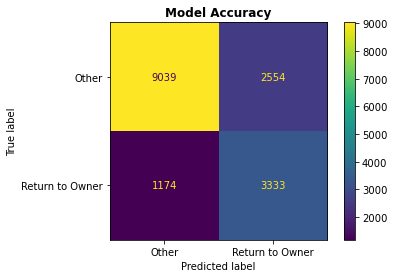

In [84]:
plot_confusion_matrix(clf, X_test, y_test, cmap='viridis')
plt.title('Model Accuracy', weight='bold')
plt.savefig('../plots/model_accuracy_confusion_matrix', dpi=300);

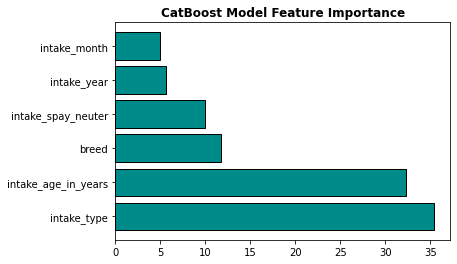

In [66]:
data = clf.get_feature_importance(prettified=True)

plt.barh(data['Feature Id'], 
         data['Importances'],
         color='darkcyan',
         edgecolor='black'
        )
plt.title('CatBoost Model Feature Importance', weight='bold')
plt.savefig('../plots/catboost_feature_importance', bbox_inches='tight', dpi=300);

In [22]:
import shap

shap.initjs()

In [23]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test) 

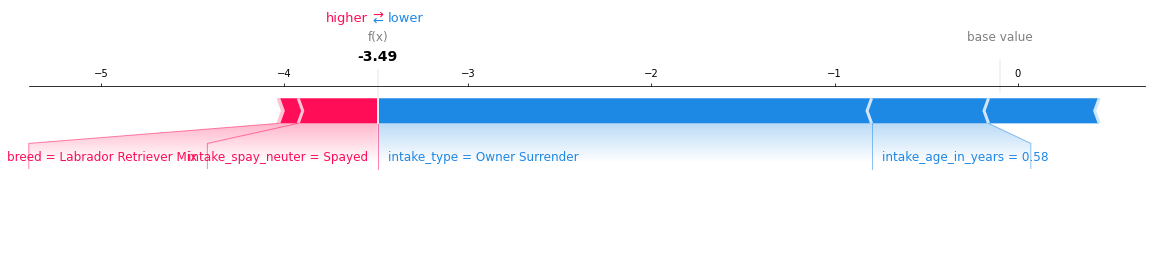

In [92]:
observation_idx = 463

shap.force_plot(explainer.expected_value, shap_values[observation_idx,:], X_test.iloc[observation_idx,:],
               show=False, matplotlib=True)

plt.savefig('../plots/other_shap_example', dpi=300, bbox_inches='tight');

In [73]:
print(y_test.iloc[463])
print(preds[463])

outcome_type    Other
Name: 63397, dtype: object
Other


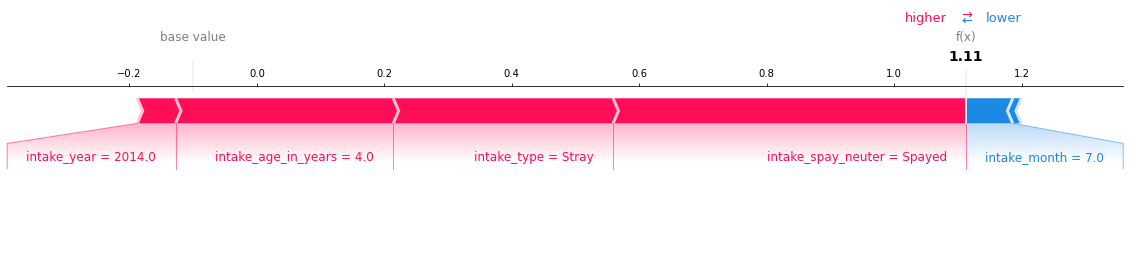

In [91]:
observation_idx = 1800

shap.force_plot(explainer.expected_value, shap_values[observation_idx,:], X_test.iloc[observation_idx,:], 
                show=False, matplotlib=True)

plt.savefig('../plots/rto_shap_example', dpi=300, bbox_inches='tight');

In [74]:
print(y_test.iloc[1800])
print(preds[1800])

outcome_type    Return to Owner
Name: 8197, dtype: object
Return to Owner


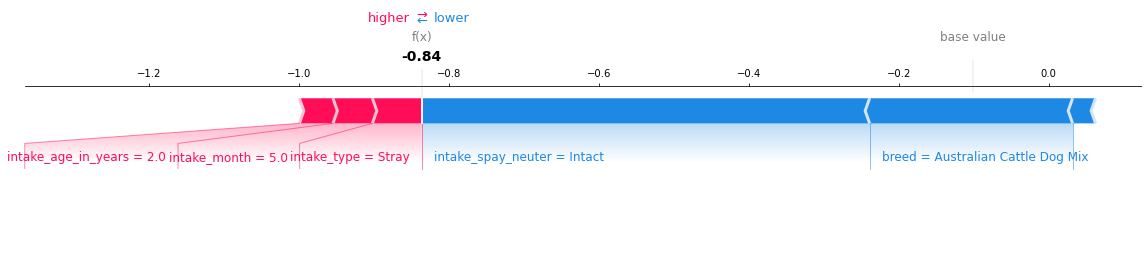

In [99]:
observation_idx = 2100

shap.force_plot(explainer.expected_value, shap_values[observation_idx,:], X_test.iloc[observation_idx,:],
                show=False, matplotlib=True)

plt.savefig('../plots/incorrect_shap_example', dpi=300, bbox_inches='tight');

In [93]:
print(y_test.iloc[2100])
print(preds[2100])

outcome_type    Return to Owner
Name: 16958, dtype: object
Other


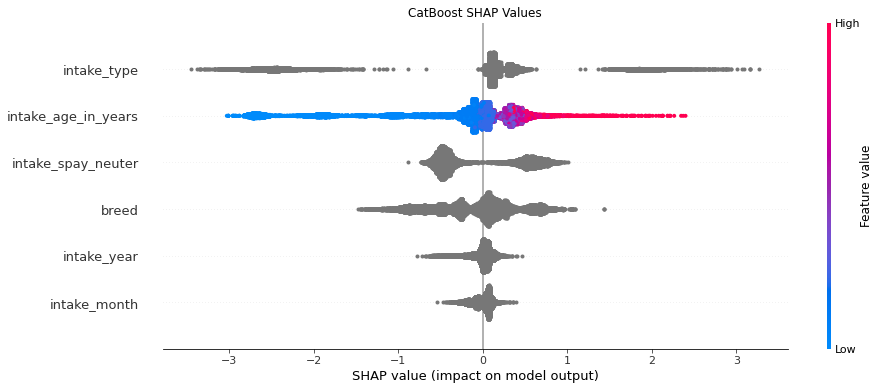

In [87]:
shap.summary_plot(shap_values, X_test, plot_size = (14,6), show=False)
plt.title('CatBoost SHAP Values')
plt.savefig('../plots/shap_summary', dpi=300, bbox_inches='tight')

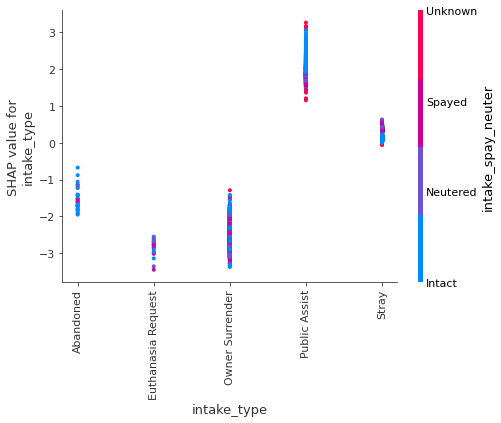

In [29]:
shap.dependence_plot('intake_type', shap_values, X_test)

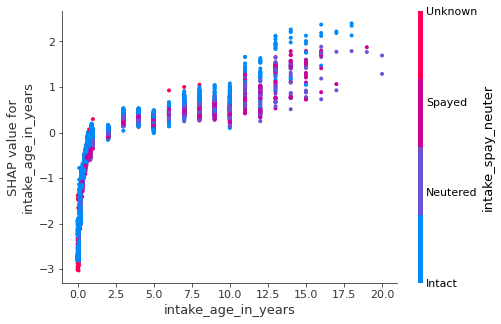

In [27]:
shap.dependence_plot('intake_age_in_years', shap_values, X_test)